In [1370]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
import scipy.stats as stats
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from statsmodels.tsa.api import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [1371]:
palette_tab10 = sns.color_palette("tab10", 10)
cmap = sns.color_palette([palette_tab10[0], palette_tab10[1]], as_cmap=True)
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

Read the data

In [1372]:
DIR_SUBJECT_1 = '../udataset/meat/production.csv'
# DIR_SUBJECT_1 = '../udataset/meat/cold_storage.csv'
# DIR_SUBJECT_1 = '../udataset/meat/slaughter.csv'
# DIR_SUBJECT_1 = '../udataset/meat/weights.csv'
df_subject1 = pd.read_csv(DIR_SUBJECT_1)
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Other Chicken,Turkey,Red Meat,Poultry
0,1921-01,3.580000e+08,27000000.0,5.650000e+08,44000000.0,NaN,NaN,393000000.0,9.940000e+08,3.930000e+08
1,1921-02,2.790000e+08,24000000.0,4.840000e+08,39000000.0,NaN,NaN,NaN,8.260000e+08,0.000000e+00
2,1921-03,3.400000e+08,31000000.0,3.720000e+08,45000000.0,NaN,NaN,NaN,7.880000e+08,0.000000e+00
3,1921-04,3.160000e+08,29000000.0,3.740000e+08,41000000.0,NaN,NaN,NaN,7.600000e+08,0.000000e+00
4,1921-05,3.190000e+08,31000000.0,3.960000e+08,37000000.0,NaN,NaN,NaN,7.830000e+08,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,51100000.0,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,48400000.0,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,50600000.0,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,44500000.0,500300000.0,4.638900e+09,4.362100e+09


In [1373]:
# DIR_SUBJECT_2 = '../udataset/unemployment_month_US.csv'
# DIR_SUBJECT_2 = '../dataset/youth_unemployment_rate.csv'
DIR_SUBJECT_2 = '../dataset/national_hourly_earnings.csv'
df_subject2 = pd.read_csv(DIR_SUBJECT_2)
df_subject2

,YearMonth,HourlyEarnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Make variables for specific dataset 1

In [1374]:
# For meat production
df_subject1 = df_subject1.drop(columns=['Other Chicken'])
df_subject1 = df_subject1.dropna()
MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'red_meat', 'poultry']
SUBJECT1 = 'meat_production'
UNIT = 'Pounds'

# For meat cold storage
# MEAT_TYPE = ['beef', 'veal', 'pork', 'lamb_and_mutton', 'broiler', 'turkey', 'frozen_egg', 'red_meat', 'poultry']

SUBJECT_TITLE1 = SUBJECT1.replace('_', ' ').title()
df_subject1

,DateTime,Beef,Veal,Pork,Lamb and Mutton,Broiler,Turkey,Red Meat,Poultry
648,1977-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
649,1977-02,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
650,1977-03,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
651,1977-04,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
652,1977-05,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
1207,2023-08,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
1208,2023-09,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
1209,2023-10,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
1210,2023-11,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


Make variables for specific dataset 2

In [1375]:
# # For unemployment_month_US.csv
# df_subject2 = df_subject2.rename(columns={'Year-Month': 'datetime'})
# SUBJECT2 = 'unemployment_rate'

# # For youth_unemployment_rate.csv
# df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'UnemploymentRate': 'unemployment_rate'})
# SUBJECT2 = 'unemployment_rate'

# For national_hourly_earnings.csv
df_subject2 = df_subject2.rename(columns={'YearMonth': 'datetime', 'HourlyEarnings': 'hourly_earnings'})
SUBJECT2 = 'hourly_earnings'

SUBJECT_TITLE2 = SUBJECT2.replace('_', ' ').title()
df_subject2

,datetime,hourly_earnings
0,2006-03,20.07
1,2006-04,20.36
2,2006-05,20.06
3,2006-06,20.04
4,2006-07,20.28
...,...,...
212,2023-11,34.08
213,2023-12,34.26
214,2024-01,34.67
215,2024-02,34.61


Change label format to be lower + underscores instead of space

In [1376]:
df_subject1.columns = df_subject1.columns.str.lower().str.replace(' ', '_')
df_subject2.columns = df_subject2.columns.str.lower().str.replace(' ', '_')

Change date format to better use together

In [1377]:
df_subject1['datetime'] = pd.to_datetime(df_subject1['datetime'])
df_subject2['datetime'] = pd.to_datetime(df_subject2['datetime'])
df_subject2

,datetime,hourly_earnings
0,2006-03-01,20.07
1,2006-04-01,20.36
2,2006-05-01,20.06
3,2006-06-01,20.04
4,2006-07-01,20.28
...,...,...
212,2023-11-01,34.08
213,2023-12-01,34.26
214,2024-01-01,34.67
215,2024-02-01,34.61


In [1378]:
df_subject1.reset_index(drop=True, inplace=True)
df_subject1

,datetime,beef,veal,pork,lamb_and_mutton,broiler,turkey,red_meat,poultry
0,1977-01-01,1.976000e+09,50000000.0,9.770000e+08,28000000.0,7.138000e+08,146500000.0,3.031000e+09,8.603000e+08
1,1977-02-01,1.847000e+09,47000000.0,9.680000e+08,26000000.0,6.592000e+08,70500000.0,2.888000e+09,7.297000e+08
2,1977-03-01,2.041000e+09,53000000.0,1.206000e+09,33000000.0,7.832000e+08,58700000.0,3.333000e+09,8.419000e+08
3,1977-04-01,1.856000e+09,44000000.0,1.077000e+09,30000000.0,7.449000e+08,80300000.0,3.007000e+09,8.252000e+08
4,1977-05-01,1.864000e+09,43000000.0,1.003000e+09,25000000.0,8.099000e+08,78900000.0,2.935000e+09,8.888000e+08
...,...,...,...,...,...,...,...,...,...
551,2023-08-01,2.329500e+09,4100000.0,2.282400e+09,8900000.0,4.156700e+09,433500000.0,4.624900e+09,4.641300e+09
552,2023-09-01,2.114600e+09,3500000.0,2.175500e+09,8600000.0,3.805500e+09,489200000.0,4.302200e+09,4.343100e+09
553,2023-10-01,2.300800e+09,4000000.0,2.406200e+09,9800000.0,4.177300e+09,431200000.0,4.720800e+09,4.659100e+09
554,2023-11-01,2.247300e+09,4100000.0,2.377400e+09,10100000.0,3.817300e+09,500300000.0,4.638900e+09,4.362100e+09


# Stationary analysis

Check for stationarity

In [1379]:
def test_stationarity(timeseries, title, verbose=False):
    title = title.replace('_', ' ').title()

    result = adfuller(timeseries, autolag='AIC')
    adf_stat = result[0]
    p_val = result[1]
    used_lag = result[2]
    n_obs = result[3]
    critical_val = result[4]
    icbest = result[5]

    if verbose:
        # Print the results in a more structured report format
        print(f"Augmented Dickey-Fuller Test Results for {title}:")
        print("-------------------------------------")
        print(f"Test Statistic: {adf_stat:.4f}")
        print(f"P-value: {p_val:.4f}")
        print(f"Number of Lags Used: {used_lag}")
        print(f"Number of Observations Used: {n_obs}")
        print("Critical Values:")
        for key, value in critical_val.items():
            print(f"    {key} ({value:.4f})")
        print(f"Information Criterion (best): {icbest:.4f}")
        print("Conclusion:")
        if p_val < 0.05:
            print("The time series is stationary with 95% confidence.")
        else:
            print("The time series is not stationary. Consider differencing or detrending.")

    if p_val < 0.05:
        return 1
    else:
        return 0

# ARIMA

Split train test data

In [1380]:
MAIN_MEAT = 'beef'
diff_meat = df_subject1.copy()
diff_meat = diff_meat[['datetime', MAIN_MEAT]]
diff_meat[MAIN_MEAT] = diff_meat[MAIN_MEAT].diff().diff()
diff_meat.dropna(inplace=True)
merged_df = df_subject2.merge(diff_meat, on='datetime', how='inner')
diff_meat

,datetime,beef
2,1977-03-01,323000000.0
3,1977-04-01,-379000000.0
4,1977-05-01,193000000.0
5,1977-06-01,177000000.0
6,1977-07-01,-380000000.0
...,...,...
551,2023-08-01,475800000.0
552,2023-09-01,-467200000.0
553,2023-10-01,401100000.0
554,2023-11-01,-239700000.0


In [1381]:
LEARN_TO_YEAR = 2018
LEARN_FROM = date(1900, 1, 1)
LEARN_TO = date(LEARN_TO_YEAR, 6, 1)
train_df = merged_df[(merged_df['datetime'].dt.date >= LEARN_FROM) & (merged_df['datetime'].dt.date <= LEARN_TO)]
train_df = train_df.set_index('datetime')
train_df = train_df.asfreq('MS')
train_df

,hourly_earnings,beef
datetime,,
2006-03-01,20.07,594600000.0
2006-04-01,20.36,-605400000.0
2006-05-01,20.06,568600000.0
2006-06-01,20.04,-198800000.0
2006-07-01,20.28,-368600000.0
...,...,...
2018-02-01,26.84,-417400000.0
2018-03-01,26.87,510300000.0
2018-04-01,27.16,-303600000.0


In [1382]:
TEST_FROM = date(2018, 6, 1)
TEST_TO = date(2018, 12, 1)
test_df = merged_df[(merged_df['datetime'].dt.date >= TEST_FROM) & (merged_df['datetime'].dt.date <= TEST_TO)]
test_df = test_df.set_index('datetime')
test_df = test_df.asfreq('MS')
test_df

,hourly_earnings,beef
datetime,,
2018-06-01,26.79,-195500000.0
2018-07-01,27.10,-64100000.0
2018-08-01,27.00,264900000.0
2018-09-01,27.45,-468300000.0
2018-10-01,27.31,539100000.0
2018-11-01,27.35,-373700000.0
2018-12-01,27.69,-90100000.0


In [1383]:
month_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)

Variables of choice to train on

In [1384]:
y = train_df[SUBJECT2]
MEAT_CHOICE = 'beef'
x = train_df[MEAT_CHOICE]

Define main SARIMAX model components

In [1385]:
def forecast_sarimax(endog, exog, ordp, ordd, ordq, seasp, seasd, seasq, s, method):
    model = SARIMAX(endog, exog=exog,
                order=(ordp, ordd, ordq),
                seasonal_order=(seasp, seasd, seasq, s),
                enforce_stationarity=True,
                enforce_invertibility=True)
    model_fit = model.fit(disp=0, method=method)
    return model_fit

In [1386]:
def model_predict(model, exog, month_gap):
    # test_df[MEAT_CHOICE] for exog
    forecast = model.get_forecast(steps=month_gap + 7, exog=exog)
    predict_mean = forecast.predicted_mean
    confidence_interval = forecast.conf_int()
    return predict_mean, confidence_interval

In [1387]:
def plot_pred_test(mean, conf, train_df, test_df, with_title):
    print(mean)
    plt.figure(figsize=(12, 6))
    last_row = train_df.tail(1)
    last_row['predict_mean'] = last_row[['hourly_earnings']]
    new_mean = pd.concat([last_row['predict_mean'], mean])
    filtered_df = train_df[str(LEARN_TO_YEAR):]
    forecast_aligned = new_mean.loc[test_df.index]
    plt.plot(filtered_df.index, filtered_df[SUBJECT2], label='Train')
    plt.plot(test_df.index, test_df[SUBJECT2], label='Test')
    plt.plot(test_df.index, forecast_aligned, label='Forecast')
    # plt.fill_between(test_df.index, conf.iloc[:, 0], conf.iloc[:, 1], color='k', alpha=0.1)
    plt.title(f'{SUBJECT_TITLE2} Forecasting {with_title}')
    plt.legend()
    plt.show()

In [1388]:
def mae(mean, endog):
    # test_df[SUBJECT2] = endog
    return np.abs(endog - mean).mean()

Do SARIMAX for forecasting wages no exog

Figure(1200x1200)


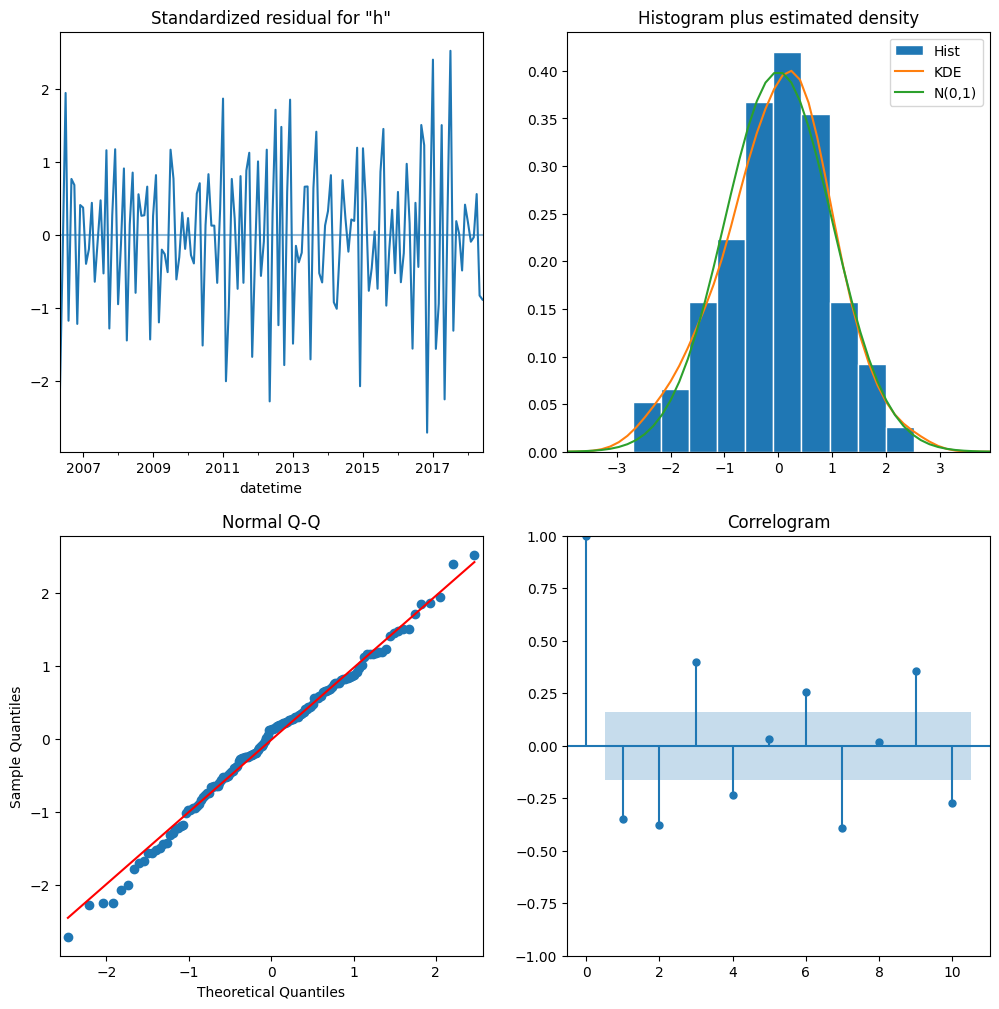

In [1389]:
ordp, ordq, seap, seasd, seasq, method = (1, 0, 1, 0, 1, 'nm')
ordd = 2
s = 12

# Model without meat
base_model = forecast_sarimax(endog=y, exog=None, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

Get forecast with model

In [1390]:
base_forecast_mean, base_forecast_conf = model_predict(model=base_model, exog=None, month_gap=month_gap)

Plot data

2018-07-01    26.890133
2018-08-01    26.719684
2018-09-01    26.750212
2018-10-01    26.691493
2018-11-01    26.577353
2018-12-01    26.542659
2019-01-01    26.532060
Freq: MS, Name: predicted_mean, dtype: float64


/tmp/ipykernel_319557/3779264998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_row['predict_mean'] = last_row[['hourly_earnings']]


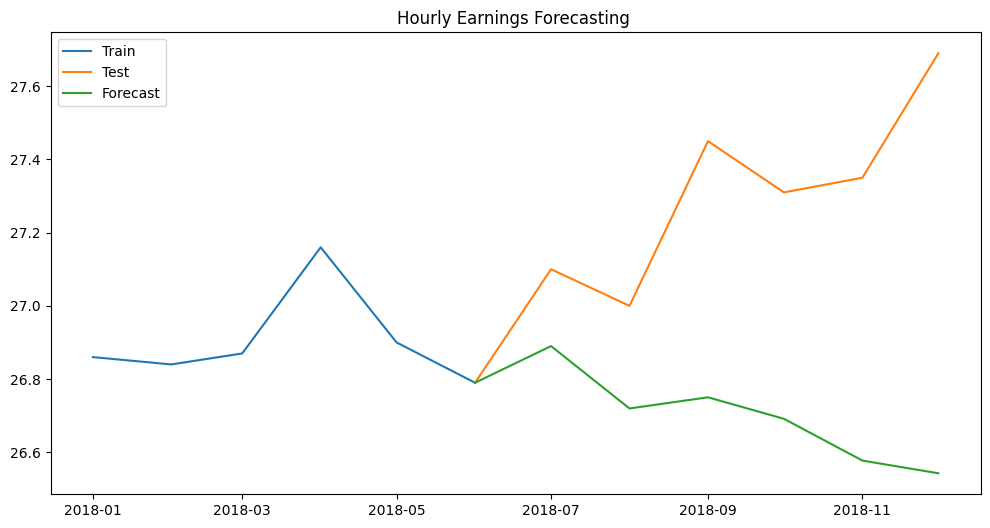

In [1391]:
plot_pred_test(mean=base_forecast_mean, conf=base_forecast_conf,
               train_df=train_df, test_df=test_df, with_title='')

Calculate MAE

In [1392]:
mae(base_forecast_mean, test_df[SUBJECT2])

0.6214109292067794

Do the same as above but with actual meat data as exog

/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Figure(1200x1200)


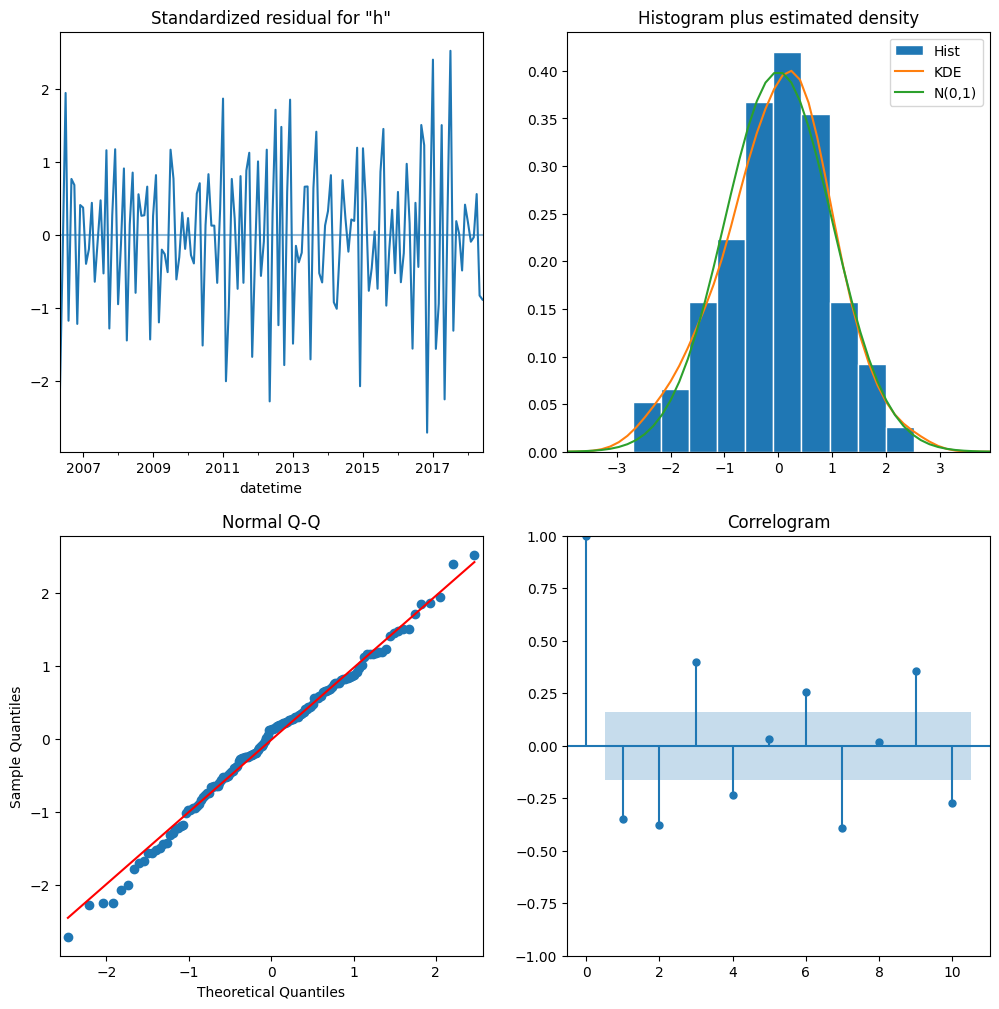

In [1393]:
ordp, ordq, seap, seasd, seasq, method = (0, 2, 0, 2, 1, 'powell')
ordd = 2
s = 12

model_with_actual_meat = forecast_sarimax(endog=y, exog=x, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

In [1394]:
actual_meat_forecast_mean, actual_meat_forecast_conf = model_predict(model=model_with_actual_meat, exog=test_df[MEAT_CHOICE], month_gap=month_gap)

2018-07-01    27.084532
2018-08-01    26.984003
2018-09-01    27.135698
2018-10-01    27.477656
2018-11-01    27.166772
2018-12-01    27.383526
2019-01-01    27.702607
Freq: MS, Name: predicted_mean, dtype: float64


/tmp/ipykernel_319557/3779264998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_row['predict_mean'] = last_row[['hourly_earnings']]


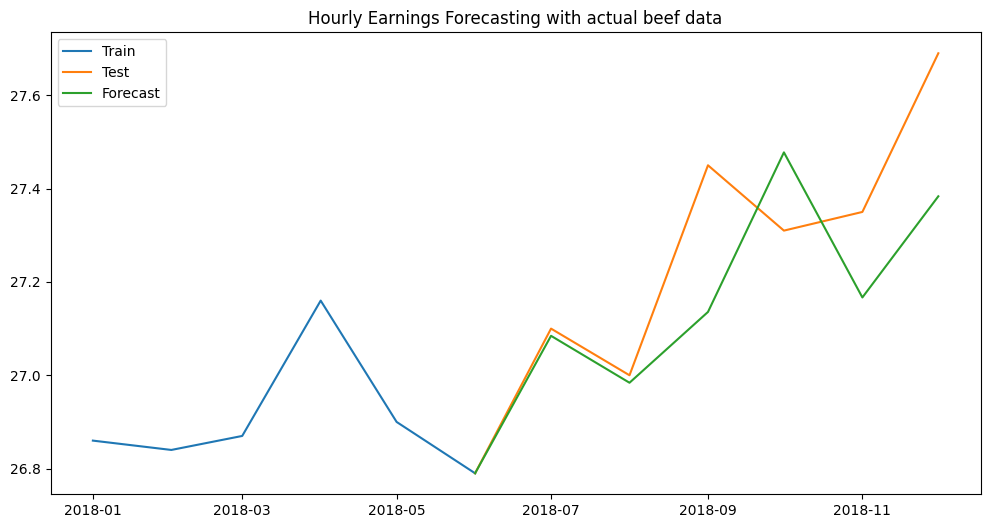

In [1395]:
plot_pred_test(mean=actual_meat_forecast_mean, conf=actual_meat_forecast_conf,
               train_df=train_df, test_df=test_df, with_title=f'with actual {MEAT_CHOICE} data')

In [1396]:
mae(actual_meat_forecast_mean, test_df[SUBJECT2])

0.16718747059000627

Do the same but with predicted meat data as exog

/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/lehoa/src/citadel-datathon/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Figure(1200x1200)


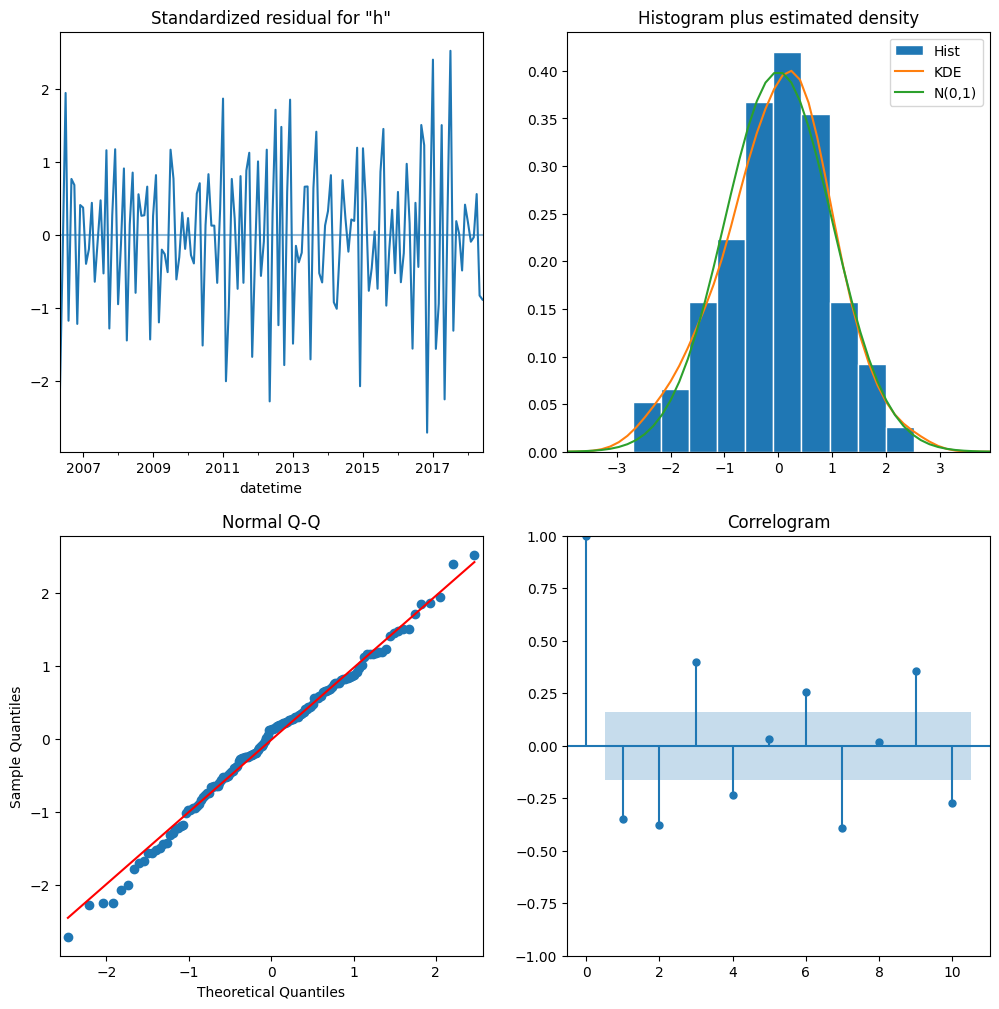

In [1397]:
ordp, ordq, seap, seasd, seasq, method = (0, 2, 0, 2, 1, 'powell')
ordd = 2
s = 12

model_with_predicted_meat = forecast_sarimax(endog=y, exog=x, ordp=ordp,
                              ordq=ordq, ordd=ordd,
                              seasp=seap, seasd=seasd,
                              seasq=seasq, s=s, method=method)
print(base_model.plot_diagnostics(figsize=(12, 12)))

In [1398]:
PATH = '../model/sarimax_meat_forecasting.pkl'
with open(PATH, 'rb') as file:
    sarimax_meat = pickle.load(file)
pred_meat = sarimax_meat.get_forecast(steps=7)
pred_meat.predicted_mean

2018-07-01    2.211919e+09
2018-08-01    2.335195e+09
2018-09-01    2.188177e+09
2018-10-01    2.291339e+09
2018-11-01    2.130691e+09
2018-12-01    2.085476e+09
2019-01-01    2.211529e+09
Freq: MS, Name: predicted_mean, dtype: float64

In [1399]:
pred_meat_forecast_mean, pred_meat_forecast_conf = model_predict(model=model_with_predicted_meat, exog=pred_meat.predicted_mean, month_gap=month_gap)

2018-07-01    26.793751
2018-08-01    26.694202
2018-09-01    26.903394
2018-10-01    27.144332
2018-11-01    26.974531
2018-12-01    27.086493
2019-01-01    27.424603
Freq: MS, Name: predicted_mean, dtype: float64


/tmp/ipykernel_319557/3779264998.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_row['predict_mean'] = last_row[['hourly_earnings']]


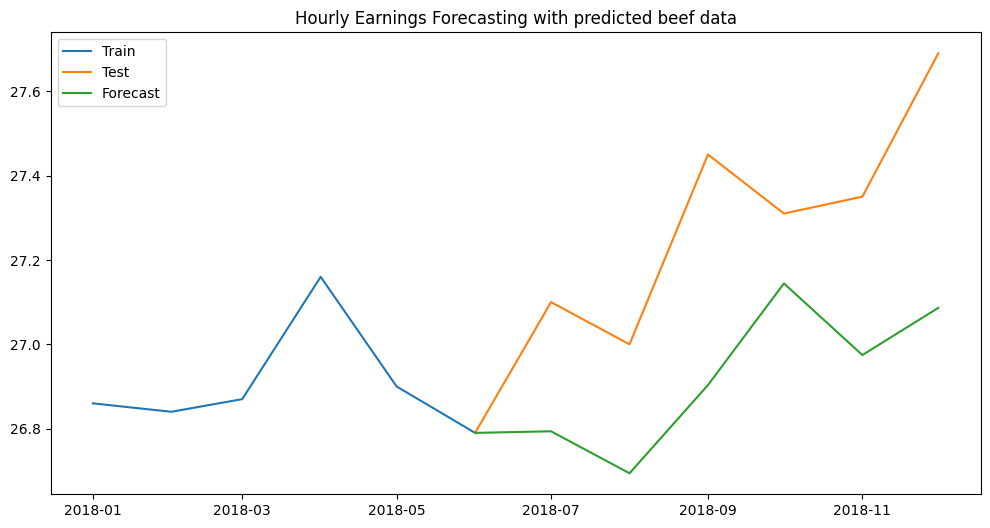

In [1400]:
plot_pred_test(mean=pred_meat_forecast_mean, conf=pred_meat_forecast_conf,
               train_df=train_df, test_df=test_df, with_title=f'with predicted {MEAT_CHOICE} data')

In [1401]:
mae(pred_meat_forecast_mean, test_df[SUBJECT2])

0.38388290113650747

In [1402]:
# LEARN_TO_YEAR = 2018
# LEARN_FROM = date(1900, 1, 1)
# LEARN_TO = date(LEARN_TO_YEAR, 1, 1)
# train_df = merged_df[(merged_df['datetime'].dt.date >= LEARN_FROM) & (merged_df['datetime'].dt.date < LEARN_TO)]
# train_df = train_df.set_index('datetime')
# train_df = train_df.asfreq('MS')

In [1403]:
# TEST_FROM = date(2018, 1, 1)
# TEST_TO = date(2018, 7, 1)
# test_df = merged_df[(merged_df['datetime'].dt.date >= TEST_FROM) & (merged_df['datetime'].dt.date < TEST_TO)]
# test_df = test_df.set_index('datetime')
# test_df = test_df.asfreq('MS')

In [1404]:
# month_gap = (TEST_FROM.year - LEARN_TO.year) * 12 + (TEST_FROM.month - LEARN_TO.month)

Variables of choice to train on

In [1405]:
# y = train_df[SUBJECT2]
# MEAT_CHOICE = 'beef'
# x = train_df[MEAT_CHOICE]

Do grid-seach to find best MAE

In [1406]:
# def grid_search(endog, exog, test_endog, test_exog, search_depth=3):
#     param_grid = {
#         'ord_p': range(0, search_depth),
#         'ord_q': range(0, search_depth),
#         'season_p': range(0, search_depth),
#         'season_d': range(0, search_depth),
#         'season_q': range(0, search_depth),
#         'opt': ['lbfgs', 'nm', 'powell']
#     }
#     parameter_combinations = list(product(*param_grid.values()))
#     best_params = None
#     best_mae = float('inf')
#     for param in parameter_combinations:
#         model_fit = forecast_sarimax(endog, exog, param[0], 2, param[1], param[2], param[3], param[4], 12, param[5])
#         predict_mean, _ = model_predict(model_fit, test_exog, month_gap)
#         cur_mae = mae(predict_mean, test_endog)
#         if cur_mae < best_mae:
#             best_mae = cur_mae
#             best_params = param
#             print(f'Best MAE: {best_mae}, best params: {best_params} so far')

#     return (best_params, best_mae)

# best_param, best_mae = grid_search(endog=train_df[SUBJECT2],
#                                    exog=train_df[MEAT_CHOICE],
#                                    test_exog=test_df[MEAT_CHOICE],
#                                    test_endog=test_df[SUBJECT2],
#                                    search_depth=3)
# print(best_param, best_mae)